In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

from utils.image_formatting import *

%load_ext autoreload
%autoreload 2

n=64

In [2]:
X, y = preprocess_images2(artists=list(PAINTER_DICT.keys()), n_imgs=1000, img_res=(n, n), dropout_rate=None)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, _ , _ = train_test_split(X, y, test_size=0.1)   

print(X_train.shape)
print(X_val.shape)

(7207, 64, 64, 3)
(801, 64, 64, 3)


In [3]:
# accuracy reach 72%
CAE = Sequential()
CAE.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               input_shape=(n, n, 3), 
               padding='same', name = 'Conv2D_1'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_1'))

CAE.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_2'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_2'))

CAE.add(Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), 
               activation='relu', 
               padding='same', 
               name='Conv2D_3'))
CAE.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='MaxPool_3'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_1'))
CAE.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='DeConv2D_1'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_2'))
CAE.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_2'))

CAE.add(UpSampling2D(interpolation='bilinear', name='UpSample_3'))
CAE.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same', name='De2DTrans_3'))

CAE.add(Conv2DTranspose(filters=3, kernel_size=(1, 1), strides=(1, 1), activation='relu', name='Conv2DTrans_recon'))
CAE.summary()
CAE.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
            loss=keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.Accuracy())        # compile model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 8, 8, 128)         0         
_________________________________________________________________
UpSample_1 (UpSampling2D)    (None, 16, 16, 128)       0

In [4]:
# Train CAE (Unsupervised Training)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            min_delta = 2, 
                                            mode = 'min', 
                                            patience=3)
CAE_train_history = CAE.fit(x=X_train, y=X_train, 
                            batch_size=32, 
                            epochs=30, 
                            validation_data=(X_val, X_val),
                            callbacks=[callback])

Epoch 1/30
226/226 [==============================] - 10s 28ms/step - loss: 12969.9833 - accuracy: 0.0046 - val_loss: 1015.7183 - val_accuracy: 0.0076
Epoch 2/30
226/226 [==============================] - 6s 24ms/step - loss: 847.2799 - accuracy: 0.0082 - val_loss: 681.1071 - val_accuracy: 0.0132
Epoch 3/30
226/226 [==============================] - 6s 25ms/step - loss: 638.1961 - accuracy: 0.0135 - val_loss: 760.1333 - val_accuracy: 0.0139
Epoch 4/30
226/226 [==============================] - 6s 25ms/step - loss: 583.0411 - accuracy: 0.0152 - val_loss: 565.1572 - val_accuracy: 0.0143
Epoch 5/30
226/226 [==============================] - 6s 25ms/step - loss: 530.0696 - accuracy: 0.0146 - val_loss: 504.9337 - val_accuracy: 0.0153
Epoch 6/30
226/226 [==============================] - 6s 24ms/step - loss: 493.4510 - accuracy: 0.0166 - val_loss: 506.1829 - val_accuracy: 0.0154
Epoch 7/30
226/226 [==============================] - 6s 24ms/step - loss: 467.8986 - accuracy: 0.0157 - val_loss:

In [5]:
# # Save model
# CAE_path = "models/cae"
# CAE.save(CAE_path)

In [6]:
# from tensorflow import keras
# CAE = keras.models.load_model('models/cae')

# Visualize encoded resuslts

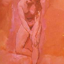

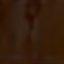

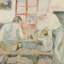

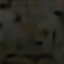

In [7]:
# show the output of reconstruction
from PIL import Image
import numpy as np

for i in range(2):
    original_image = Image.fromarray(X[i])
#     original_image_path = 'comparison/original_image.png'
#     original_image.save(original_image_path)
    expand = np.expand_dims(X[i], 0)
    reconstruct_output = CAE(expand).numpy().reshape((n, n, 3))
    output_max = np.max(reconstruct_output)
    output_min = np.min(reconstruct_output)
    reconstruct_output = (reconstruct_output - output_min) / (output_max - output_min) * (n-1)
    reconstruct_output = reconstruct_output.astype(np.uint8)
    reconstruct_image = Image.fromarray(reconstruct_output)
#     reconstruct_image_path = 'comparison/reconstruct_image.png'
#     reconstruct_image.save(reconstruct_image_path)
    
    original_image.show()
    reconstruct_image.show()

# Train Fully Connected Layers

In [8]:
# Use the hyperparameter learned from CAE and classify the paints
# artists = ['pierre-auguste-renoir', 'vincent-van-gogh', 'pablo-picasso']
artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']
# artists=list(PAINTER_DICT.keys())

X, y = preprocess_images2(artists=artists, n_imgs=1000, img_res = (n,n), dropout_rate=0)
X_aug = np.flip(X, axis=2)
y_aug = y
X = np.concatenate((X, X_aug), axis=0)
y = np.concatenate((y, y_aug), axis=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)


print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2565, 64, 64, 3) (2565,)
(285, 64, 64, 3) (285,)


In [51]:
cae_output = Model(inputs = CAE.input, outputs = CAE.layers[-6].output, name = 'cae_output')
for layer in cae_output.layers:
    layer.trainable = False
following_layers = Sequential()
input_shape = (cae_output.output.shape[1], cae_output.output.shape[2], cae_output.output.shape[3])
following_layers.add(tf.keras.layers.Input(shape=input_shape))
following_layers.add(Flatten(name = 'flatten'))
following_layers.add(Dropout(0.1, name = "Dropout_1"))
following_layers.add(Dense(256, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_1"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(128, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_2"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(32, 
#                            activation = 'relu', 
                           kernel_regularizer = 'l2', 
#                            bias_regularizer = 'l2', 
                           name = "Dense_3"))
following_layers.add(LeakyReLU(0.05))

following_layers.add(Dense(3, activation = 'softmax', name = "softmax"))
painter_classifier = Model(inputs = cae_output.inputs, outputs = following_layers(cae_output.output))
painter_classifier.summary()
painter_classifier.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                           loss = 'sparse_categorical_crossentropy', 
                           metrics = ['accuracy'])


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
Conv2D_1 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
MaxPool_3 (MaxPooling2D)     (None, 8, 8, 128)         0   

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                            min_delta = 0.005, 
                                            mode = 'max', 
                                            patience=5)
cae_training_history = painter_classifier.fit(x=X_train, y=y_train, 
                                              batch_size=32, epochs=30, 
                                              validation_data=(X_val, y_val),
                                              callbacks = [callback])

Epoch 1/30
81/81 [==============================] - 1s 10ms/step - loss: 28.0122 - accuracy: 0.4975 - val_loss: 7.5959 - val_accuracy: 0.5930
Epoch 2/30
81/81 [==============================] - 1s 8ms/step - loss: 6.9744 - accuracy: 0.6441 - val_loss: 10.3781 - val_accuracy: 0.4982
Epoch 3/30
81/81 [==============================] - 1s 8ms/step - loss: 7.0148 - accuracy: 0.6558 - val_loss: 4.4880 - val_accuracy: 0.7228
Epoch 4/30
81/81 [==============================] - 1s 8ms/step - loss: 3.9975 - accuracy: 0.7845 - val_loss: 3.7859 - val_accuracy: 0.7439
Epoch 5/30
81/81 [==============================] - 1s 8ms/step - loss: 3.7663 - accuracy: 0.7752 - val_loss: 3.7029 - val_accuracy: 0.7474
Epoch 6/30
81/81 [==============================] - 1s 8ms/step - loss: 3.1831 - accuracy: 0.8297 - val_loss: 3.4353 - val_accuracy: 0.7825
Epoch 7/30
81/81 [==============================] - 1s 8ms/step - loss: 3.2673 - accuracy: 0.7698 - val_loss: 3.5307 - val_accuracy: 0.7193
Epoch 8/30
81/81 

# Testing

In [53]:
# artists = ['rembrandt', 'pierre-auguste-renoir', 'vincent-van-gogh']

X_true, y_true = preprocess_images2(artists=artists, n_imgs=25, img_res=(n,n), test_set=True)

print(X_true.shape, y_true.shape)

(75, 64, 64, 3) (75,)


In [54]:
y_pred = painter_classifier.predict(X_true)
y_pred = np.argmax(y_pred, axis = 1)

In [55]:
confusion_matrix(y_true, y_pred)

array([[20,  1,  4],
       [ 4, 17,  4],
       [ 4,  1, 20]])

In [56]:
accuracy_score(y_true, y_pred)

0.76